# Competition 1: Beer Quality Prediction 🍺

This notebook provides starter code for the Beer Quality Prediction competition. For full instructions, problem statement, and grading criteria, please refer to the **README.md** file.

**Quick Summary**: You will build a classification model to predict beer quality (scores 1-10) based on chemical properties. Submit your predictions to [Kaggle](https://www.kaggle.com/competitions/ift-6390-ift-3395-beer-quality-prediction/).

## Import Dependencies

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from scipy.special import softmax
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


## Load and Explore Data

Training data shape: (4469, 15)
Number of samples (n): 4469
Number of features (d): 14
Columns: ['id', 'beer_style', 'bitterness_IBU', 'diacetyl_concentration', 'lactic_acid', 'final_gravity', 'sodium', 'free_CO2', 'dissolved_oxygen', 'original_gravity', 'pH', 'gypsum_level', 'alcohol_ABV', 'fermentation_strength', 'quality']

Data types and info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4469 entries, 0 to 4468
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      4469 non-null   int64  
 1   beer_style              4469 non-null   object 
 2   bitterness_IBU          4469 non-null   float64
 3   diacetyl_concentration  4469 non-null   float64
 4   lactic_acid             4469 non-null   float64
 5   final_gravity           4469 non-null   float64
 6   sodium                  4469 non-null   float64
 7   free_CO2                4469 non-null   float64
 8   dissolve

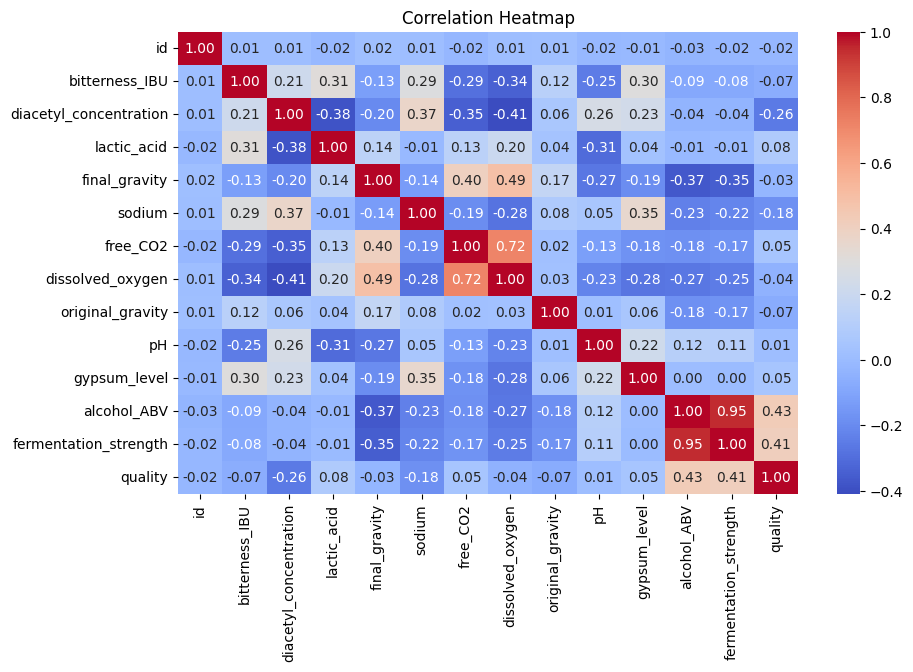

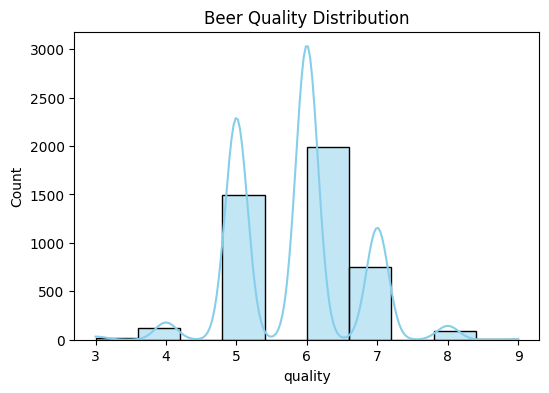

In [26]:
train_df = pd.read_csv('data/train.csv', delimiter=';')

print(f"Training data shape: {train_df.shape}")
print(f"Number of samples (n): {train_df.shape[0]}")
print(f"Number of features (d): {train_df.shape[1] - 1}")  
print(f"Columns: {list(train_df.columns)}")

print("\nData types and info:")
print(train_df.info())


plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
plt.close()


plt.figure(figsize=(6, 4))
sns.histplot(train_df['quality'], bins=10, kde=True, color='skyblue')
plt.title('Beer Quality Distribution')
plt.show()


## Data Preprocessing

Implement your preprocessing pipeline (see README.md for suggestions).

In [27]:

# Drop the quality row
X = train_df.drop('quality', axis=1)
y = train_df['quality']

initial_rows = X.shape[0]

# Drop rows with missing values
X = X.dropna()
y = y[X.index] 
dropped_rows = initial_rows - X.shape[0]
print(f" Dropped {dropped_rows} rows missing values.")

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# Numeric data is normalized and categorical data is one-hot encoded
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

X_processed = preprocessor.fit_transform(X)

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=14)  
X_selected = selector.fit_transform(X_processed, y)

print(f"Original shape: {train_df.drop('quality', axis=1).shape}")
print(f"After dropping rows: {X.shape}")
print(f"After preprocessing: {X_processed.shape}")
print(f"After feature selection: {X_selected.shape}")


 Dropped 0 rows missing values.
Original shape: (4469, 14)
After dropping rows: (4469, 14)
After preprocessing: (4469, 18)
After feature selection: (4469, 14)


## Prepare Training and Validation Data

Split your data into training and validation sets.

In [28]:
# Stratified train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_selected,      
    y,                
    test_size=0.2,    
    random_state=42, 
    stratify=y        
)

print(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Validation target distribution:\n{y_val.value_counts(normalize=True)}")


Training set shape: (3575, 14), Validation set shape: (894, 14)
Training target distribution:
quality
6    0.444196
5    0.334825
7    0.168951
4    0.026014
8    0.020699
3    0.004755
9    0.000559
Name: proportion, dtype: float64
Validation target distribution:
quality
6    0.444072
5    0.334452
7    0.168904
4    0.025727
8    0.021253
3    0.004474
9    0.001119
Name: proportion, dtype: float64


## Train Models

Train and compare multiple machine learning models.

In [29]:
X_train_gd = X_train.copy()
y_train_gd = y_train.copy()

# Convert to dense if sparse
X_train_gd = np.array(X_train_gd.todense() if hasattr(X_train_gd, "todense") else X_train_gd)
y_train_gd = np.array(y_train_gd)

# One-hot encode the labels
classes = np.unique(y_train_gd)
K = len(classes)
N, D = X_train_gd.shape

y_onehot = np.zeros((N, K))
for i, c in enumerate(classes):
    y_onehot[y_train_gd == c, i] = 1

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Initialize weights and biases
np.random.seed(42)
W = np.random.randn(D, K) * 0.01
b = np.zeros((1, K))

learning_rate = 0.05
num_epochs = 500

for epoch in range(num_epochs):
    logits = np.dot(X_train_gd, W) + b
    probs = softmax(logits)
    
    # cross-entropy loss
    loss = -np.mean(np.sum(y_onehot * np.log(probs + 1e-8), axis=1))
    
    # update weights and biases
    grad_W = np.dot(X_train_gd.T, (probs - y_onehot)) / N
    grad_b = np.mean(probs - y_onehot, axis=0, keepdims=True)
    
    W -= learning_rate * grad_W
    b -= learning_rate * grad_b
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

Epoch 0: Loss = 1.9520
Epoch 100: Loss = 1.2571
Epoch 200: Loss = 1.1480
Epoch 300: Loss = 1.1098
Epoch 400: Loss = 1.0902


## Evaluate Models

Analyze your best model's performance (see README.md for evaluation guidelines).

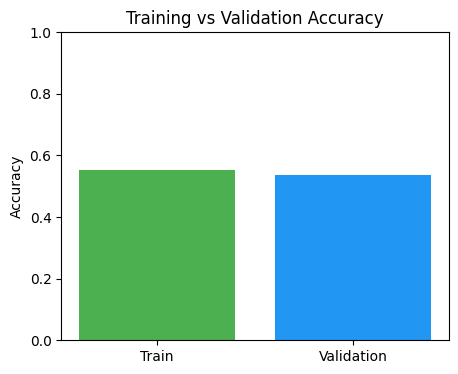

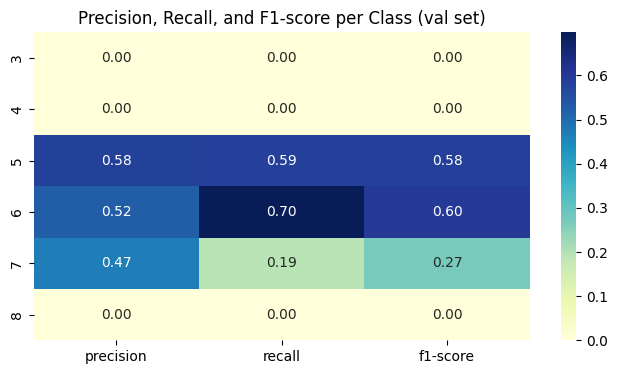

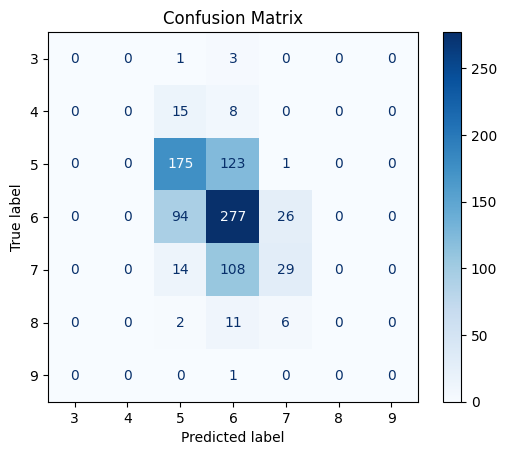

Top 10 features (by avg |weight| across classes):
Feature 0: coef magnitude = 0.2289
Feature 8: coef magnitude = 0.2185
Feature 12: coef magnitude = 0.2137
Feature 9: coef magnitude = 0.1582
Feature 11: coef magnitude = 0.1132
Feature 10: coef magnitude = 0.1112
Feature 7: coef magnitude = 0.1043
Feature 3: coef magnitude = 0.0968
Feature 2: coef magnitude = 0.0909
Feature 4: coef magnitude = 0.0897


In [30]:
def predict(X, W, b, classes):
    X_np = np.array(X.todense() if hasattr(X, "todense") else X)
    logits = np.dot(X_np, W) + b
    probs = softmax(logits)
    preds = classes[np.argmax(probs, axis=1)]
    return preds

y_train_pred = predict(X_train, W, b, classes)
y_val_pred = predict(X_val, W, b, classes)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

report = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report).transpose().drop("accuracy", errors="ignore")

plt.figure(figsize=(5,4))
plt.bar(['Train', 'Validation'], [train_acc, val_acc], color=['#4CAF50', '#2196F3'])
plt.ylim(0, 1)
plt.title("Training vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Precision, Recall, and F1-score per Class (val set)")
plt.show()

cm = confusion_matrix(y_val, y_val_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

coef_abs = np.abs(W[1:, :]).mean(axis=1) 
top_idx = np.argsort(coef_abs)[::-1][:10]

print("Top 10 features (by avg |weight| across classes):")
for i in top_idx:
    print(f"Feature {i}: coef magnitude = {coef_abs[i]:.4f}")


## Generate Predictions for Kaggle Submission

Create a CSV file with columns: `id` and `quality` (see README.md for format details).

In [31]:
test_df = pd.read_csv('data/test.csv', delimiter=';')

test_df = test_df.dropna()

ids = test_df['id']

X_test = test_df.drop(columns=['quality'], errors='ignore')

X_test_processed = preprocessor.transform(X_test)
X_test_processed = selector.transform(X_test_processed)

X_test_processed = np.array(X_test_processed.todense() if hasattr(X_test_processed, "todense") else X_test_processed)

logits_test = np.dot(X_test_processed, W) + b
probs_test = np.exp(logits_test - np.max(logits_test, axis=1, keepdims=True))
probs_test /= np.sum(probs_test, axis=1, keepdims=True)

y_test_pred = classes[np.argmax(probs_test, axis=1)]

submission = pd.DataFrame({
    'id': ids,
    'quality': y_test_pred
})

submission.to_csv('submission.csv', index=False)

---
Good luck with the competition! 🍺
